In [315]:
#* Import and settings
import os
from os import path
import re

import numpy as np
from scipy.optimize import curve_fit
import sympy as sp
from sympy import Symbol as s
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from lab_tools import graph, lab_round

%matplotlib widget

width = 469.75502 # To get the page width insert "\the\textwidth" in your LaTeX document
graph_path = "../images/"
data_path = "../data/"

mpl.rcParams.update({
    # Show minor ticks
    "ytick.minor.visible": True,
    "xtick.minor.visible": True,
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    # High resolution .png
    "savefig.dpi": 600,
    # Default image size
    "figure.figsize": graph.size(width),
})

### Variables

In [316]:
WAVE_LENGTH = 650 / 10**9

SLIT = 0.02 / 10**3
SLIT_POSITION = 4 / 10**2

SENSOR_SLIT = 1.5 / 10**3
SENSOR_POSITION = 102.5 / 10**2

distance = SENSOR_POSITION - SLIT_POSITION

### Simulation

In [317]:
I_y_expr = s('I_0') * sp.Pow(
    sp.sinc(
        sp.pi * s('a') / s(r'\lambda') * s('y') / s('L')
    ), 2
)

display(sp.Eq(
    s(r'I(y)'), I_y_expr
))

Eq(I(y), I_0*sinc(pi*a*y/(L*\lambda))**2)

In [318]:
def get_I_y(I_0, a=SLIT, l=WAVE_LENGTH, L=distance):
    return sp.lambdify(
        [s('y')],
        I_y_expr.subs({
            s('I_0'): I_0,
            s('a'): a,
            s(r'\lambda'): l,
            s('L'): L,
        })
    )


Text(0, 0.5, 'I')

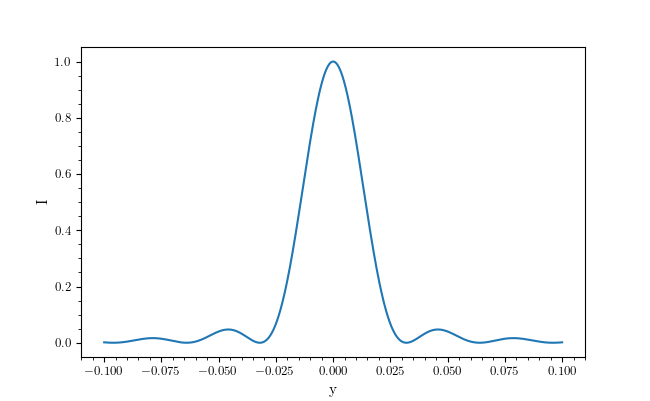

In [319]:
x = np.linspace(-0.1, 0.1, 1000)
I_y = get_I_y(1)

fig, ax = plt.subplots(1, 1)
ax.plot(x, I_y(x))

ax.set_xlabel("y")
ax.set_ylabel("I")

### Data

In [320]:
file_list = [
    file
    for file in os.listdir(data_path)
    if re.search(f"{SLIT * 10**3:.2f}_{SENSOR_SLIT * 10**3:.1f}_[\\d]+_[\\w]", file)
]

df_list = [
    pd.read_csv(
        path.join(data_path, file),
        sep=r"\t",
        engine="python",
    ) for file in file_list
]

n_set = len(df_list)

file_list

['0.02_1.5_100_An.tsv',
 '0.02_1.5_100_Ar.tsv',
 '0.02_1.5_100_Fl.tsv',
 '0.02_1.5_100_VA.tsv']

Make minimum position $y = 0$

In [321]:
for df in df_list:
    df.y -= np.min(df.y)

Split each set in 2 and make each new set start from 0 and growing

In [322]:
df_list_split = []

for df in df_list:
    max_y_index = np.argmin(df.y)

    df_list_split.append(df[max_y_index::-1].reset_index(drop=True))
    df_list_split.append(df[max_y_index:].reset_index(drop=True))

df_list = df_list_split
n_set = len(df_list)

# debug
# for i, df in enumerate(df_list):
#     print(f"Set {i + 1}")
#     print(df.head())
#     print()

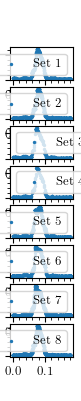

In [323]:
fig, axs = plt.subplots(n_set, 1, figsize = graph.size(width / n_set, subplots=(n_set, 1)))
axs = axs.flatten()

for i, df in enumerate(df_list):
    ax = axs[i]
    ax.scatter(df.y, df.I, s=2, label=f"Set {i + 1}")
    ax.legend()

# Compare data and simulation

In [324]:
peak_index_list = [np.argmax(df.I) for df in df_list]
peak_y_list = [df.y[i] for i, df in zip(peak_index_list, df_list)]
shift = np.mean(peak_y_list)
shift

0.07550053990257732

For SLIT $= 0.08$ (better peak) shift $= 0.08142071170739353$

In [325]:
shift = 0.08

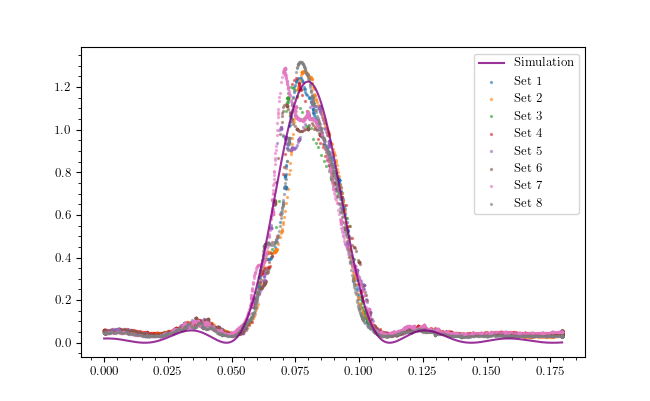

In [326]:
x = np.linspace(
    np.min([
        np.min(df.y) for df in df_list
    ]),
    np.max([
        np.max(df.y) for df in df_list
    ]),
    1000
)

I_y = get_I_y(
    np.mean([
        np.max(df.I) for df in df_list
    ])
)

fig, ax = plt.subplots(1, 1)

ax.plot(x, I_y(x - shift), label="Simulation", color="purple", alpha=0.8)

for i, df in enumerate(df_list):
    ax.scatter(df.y, df.I, s=2, label=f"Set {i + 1}", alpha=0.5)

ax.legend()